In [1]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

matplotlib.style.use('ggplot')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import os
import seaborn as sns

torch.manual_seed(2021)
np.random.seed(2021)

In [2]:
def wasserstein1d(x, y):
    x1, _ = torch.sort(x, dim=0)
    y1, _ = torch.sort(y, dim=0)
    z = (x1-y1).view(-1)
    n = x.size(0)
    return torch.dot(z, z)

In [3]:
mean = torch.Tensor([-5, 2])
std = torch.Tensor([1, 1])

In [4]:
# Optional: we can use this cell to generate sample with Pytorch built-in functions
# mix = torch.distributions.Categorical(torch.Tensor([.25,.75]))
# comp = torch.distributions.Normal(mean, std)
# gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)
# X_data = gmm.sample([5000])

In [5]:
num_samples = 5000
#########################
mixture_coef = [1/4, 3/4]
locations = [-5, 2]
scales = [1, 1]
labels = np.random.choice([0,1],size=num_samples,p=mixture_coef)
X = torch.Tensor()
for i in range(num_samples):
    idx = labels[i]
    x = locations[idx]+scales[idx]*torch.randn(1)
    X = torch.cat((X,x))
X_data = X.reshape(X.size(0),1)
#########################

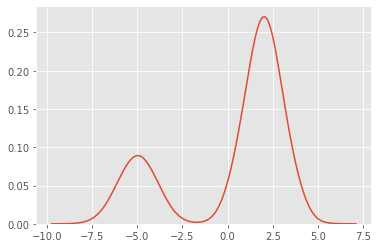

In [6]:
sns.kdeplot(X_data.squeeze().numpy())

## With critic

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        gain = nn.init.calculate_gain('leaky_relu', 0.01)
        torch.nn.init.xavier_normal_(m.weight, gain=gain)
        m.bias.data.fill_(0.01)
        
class Generator(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Generator, self).__init__()
        self.model = nn.Sequential(nn.Linear(D_in, H),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H),
                                   nn.Linear(H, H//2),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H//2),
                                   torch.nn.Linear(H//2, D_out)
                                  )
        self.model.apply(init_weights)

    def forward(self, x):
        mu = self.model(x)
        return mu
    
class Critic(torch.nn.Module):
    def __init__(self, D_in, H, D_out=1):
        super(Critic, self).__init__()
        self.model = nn.Sequential(nn.Linear(D_in, H),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H),
                                   nn.Linear(H, H//2),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H//2),
                                   nn.Linear(H//2, D_out)
                                  )
        self.model.apply(init_weights)
        
    def forward(self, x):
        logit = self.model(x)
        return logit
    

class Projector(torch.nn.Module):
    def __init__(self, D_in=1, D_out=1):
        super(Projector, self).__init__()
        self.model = nn.Sequential(nn.Linear(D_in, D_out))
        self.model.apply(init_weights)
    def forward(self, x):
        logit = self.model(x)
        return (logit)
    

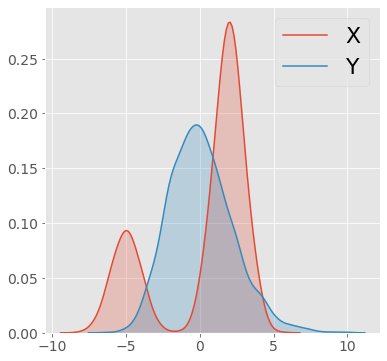

Epoch 0: 	 ploss 4.179988384246826  	 gloss 4.293971061706543 	 loss 4.236979722976685 


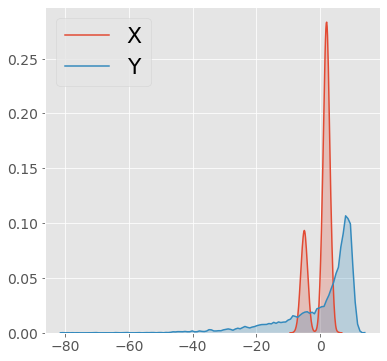

Epoch 100: 	 ploss 4.33798360824585  	 gloss 3.0108611583709717 	 loss 3.6744223833084106 


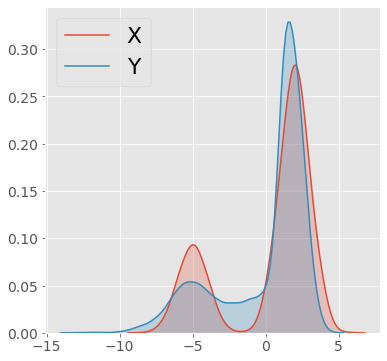

Epoch 200: 	 ploss 2.389559745788574  	 gloss 2.0985074043273926 	 loss 2.2440335750579834 


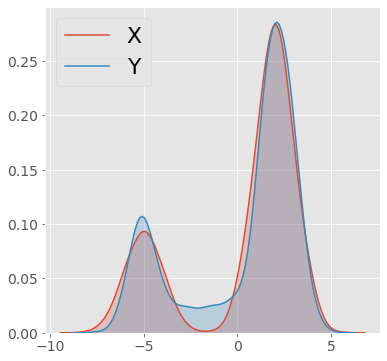

Epoch 300: 	 ploss 2.273695468902588  	 gloss 2.2702672481536865 	 loss 2.271981358528137 


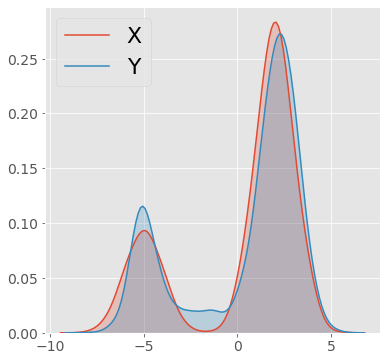

Epoch 400: 	 ploss 2.0527772903442383  	 gloss 2.0366220474243164 	 loss 2.0446996688842773 


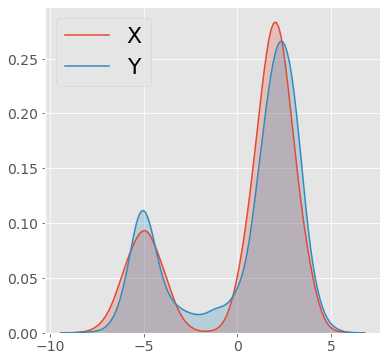

Epoch 500: 	 ploss 1.8339163064956665  	 gloss 1.8056886196136475 	 loss 1.819802463054657 


In [8]:
device = 'cuda: 1'
rho = 0.5
G = Generator(D_in=50, H=100, D_out=1).to(device)
g_opt = optim.Adam(G.parameters(), lr=1e-2)

P = Projector(D_in=10, D_out=1).to(device)
p_opt = optim.Adam(P.parameters(), lr=1e-2)

D = Critic(D_in=1, H=10, D_out=10).to(device)
d_opt = optim.Adam(D.parameters(), lr=1e-2)

p_stats = []
g_stats = []
z_fix = torch.randn(X_data.size(0), 50).to(device)
dataloader = data_utils.DataLoader(X_data, shuffle=True,
                                   batch_size=5000)

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

print_freq = 100
epochs = 500
for epoch in range(epochs+1):
    p_loss = 0
    g_loss = 0
    for i, X in enumerate(dataloader): 
        N = X.size(0)
        X = X.view(-1, 1).to(device)
        # Generate samples: B x 1
        z = torch.randn(N, 50).to(device)
        xpred = G(z)        
        
        # Extract features: B x d
        xpred_feat = D(xpred)
        x_feat = D(X)
        
        cost = torch.norm(x_feat[:,None]-xpred_feat, dim=-1).pow(2) # pairwise cost: B x B
        diff = (x_feat[:,None]-xpred_feat).pow(2)
        tmp = P(diff).squeeze() # pairwise navigator weight: B x B
        weight_x = torch.nn.functional.softmax(tmp, dim=0) # backward map
        weight_xpred = torch.nn.functional.softmax(tmp, dim=1) # forward map
        
        g_opt.zero_grad()
        p_opt.zero_grad()
        gloss = (cost * weight_xpred).sum(1).mean() # forward transport
        ploss = (cost * weight_x).sum(0).mean() # backward transport
        loss = rho * gloss + (1-rho) * ploss
        loss.backward()
        g_opt.step()
        p_opt.step()
        
        p_loss += ploss.item()
        g_loss += gloss.item()
        
        xpred = G(z)
        xpred_feat = D(xpred)
        x_feat = D(X)
        
        cost = torch.norm(x_feat[:,None]-xpred_feat, dim=-1).pow(2)

        diff = (x_feat[:,None]-xpred_feat).pow(2)
        tmp = P(diff).squeeze()
        weight_x = torch.nn.functional.softmax(tmp, dim=0)
        weight_xpred = torch.nn.functional.softmax(tmp, dim=1)

        d_opt.zero_grad()
        dloss = -((1-rho)*(cost * weight_x).sum(0).mean() + rho*(cost * weight_xpred).sum(1).mean())
        dloss.backward()
        d_opt.step()
        

    g_stats.append(g_loss/(i+1))
    p_stats.append(p_loss/(i+1))
    if epoch % print_freq == 0:
        with torch.no_grad():
            xpred = G(z_fix)
        data = pd.DataFrame(np.array([X_data.squeeze().detach().cpu().numpy(), xpred.squeeze().detach().cpu().numpy()]).T, columns=['X', 'Y'])
        fig, (ax1) = plt.subplots(1,1, figsize=(6,6))
        fig = sns.kdeplot(data['X'], ax=ax1, shade=True, bw=.4)
        fig = sns.kdeplot(data['Y'], ax=ax1, shade=True, bw=.4)
        ax1.legend(prop={'size': 22})
        plt.show()
    
        print("Epoch {}: \t ploss {}  \t gloss {} \t loss {} ".format(epoch, p_loss/(i+1), g_loss/(i+1), (p_loss/(i+1)+g_loss/(i+1))/2))

## Without Critic

In [9]:
def init_weights(m):
    if type(m) == nn.Linear:
        gain = nn.init.calculate_gain('leaky_relu', 0.01)
        torch.nn.init.xavier_normal_(m.weight, gain=gain)
        m.bias.data.fill_(0.01)
        
class Generator(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Generator, self).__init__()
        self.model = nn.Sequential(nn.Linear(D_in, H),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H),
                                   nn.Linear(H, H//2),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H//2),
                                   torch.nn.Linear(H//2, D_out)
                                  )
        self.model.apply(init_weights)

    def forward(self, x):
        mu = self.model(x)
        return mu
    
class Projector(torch.nn.Module):
    def __init__(self, D_in, H, D_out=1):
        super(Projector, self).__init__()
        self.model = nn.Sequential(nn.Linear(D_in, H),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H),
                                   nn.Linear(H, H//2),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H//2),
                                   nn.Linear(H//2, D_out)
                                  )
        self.model.apply(init_weights)
        
    def forward(self, x):
        logit = self.model(x)
        return logit

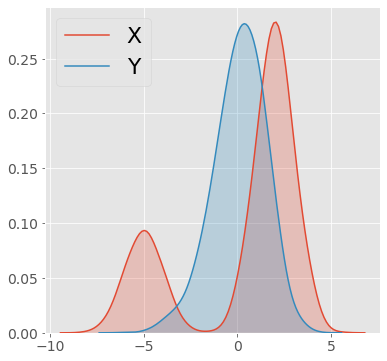

Epoch 0: 	 ploss 6.698156833648682  	 gloss 7.383780479431152 	 loss 7.040968656539917 


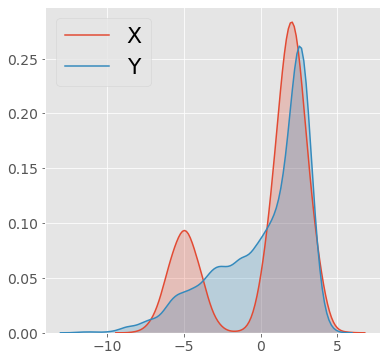

Epoch 100: 	 ploss 0.0981060042977333  	 gloss 0.05135630443692207 	 loss 0.07473115436732769 


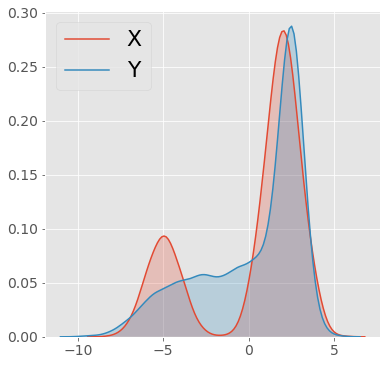

Epoch 200: 	 ploss 0.03914459049701691  	 gloss 0.028925731778144836 	 loss 0.03403516113758087 


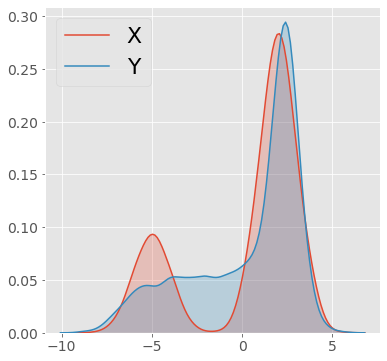

Epoch 300: 	 ploss 0.026653874665498734  	 gloss 0.019767068326473236 	 loss 0.023210471495985985 


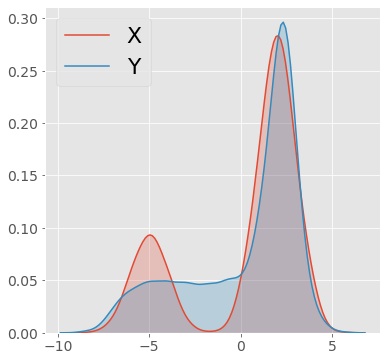

Epoch 400: 	 ploss 0.019725441932678223  	 gloss 0.015875549986958504 	 loss 0.017800495959818363 


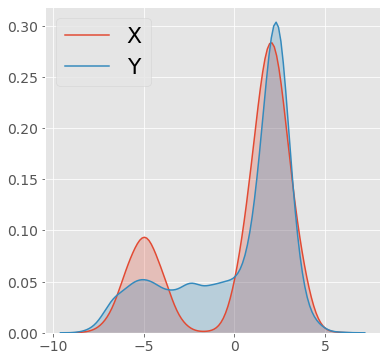

Epoch 500: 	 ploss 0.01806623674929142  	 gloss 0.015149939805269241 	 loss 0.01660808827728033 


In [10]:
device = 'cuda: 0'
G = Generator(D_in=50, H=100, D_out=1).to(device)
g_opt = optim.Adam(G.parameters(), lr=1e-2)

P = Projector(D_in=1, H=100, D_out=1).to(device)
p_opt = optim.Adam(P.parameters(), lr=1e-2)
p_stats = []
g_stats = []
z_fix = torch.randn(X_data.size(0), 50).to(device)
dataloader = data_utils.DataLoader(X_data, shuffle=True,
                                   batch_size=5000)

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

rho = 0.5

print_freq = 100
epochs = 500
for epoch in range(epochs+1):
    p_loss = 0
    g_loss = 0
    for i, X in enumerate(dataloader): 
        N = X.size(0)
        X = X.view(-1, 1).to(device)
        z = torch.randn(N, 50).to(device)
        xpred = G(z)

        X_ = X.repeat(N,1,1).transpose(0,1)
        xpred_ = xpred.repeat(N,1,1)

        diff = torch.nn.functional.mse_loss(X_, xpred_,reduction='none')
        cost = diff.sum(-1)
        tmp_x = P(X).repeat(N,1,1).transpose(0,1)
        tmp_fake = P(xpred).repeat(N,1,1)
        weight_x = torch.nn.functional.softmax(-torch.norm(tmp_x - tmp_fake, dim=-1), dim=0)
        weight_xpred = torch.nn.functional.softmax(-torch.norm(tmp_x - tmp_fake, dim=-1), dim=1)
        
        g_opt.zero_grad()
        p_opt.zero_grad()
        gloss = (cost * weight_xpred).sum(1).mean()
        ploss = (cost * weight_x).sum(0).mean()
        loss = rho * gloss + (1-rho) * ploss
        loss.backward()
        g_opt.step()
        p_opt.step()
        g_loss += gloss.item()
        p_loss += ploss.item()
        

    g_stats.append(g_loss/(i+1))
    p_stats.append(p_loss/(i+1))
    if epoch % print_freq == 0:
        with torch.no_grad():
            xpred = G(z_fix)
        data = pd.DataFrame(np.array([X_data.squeeze().detach().cpu().numpy(), xpred.squeeze().detach().cpu().numpy()]).T, columns=['X', 'Y'])
        fig, (ax1) = plt.subplots(1,1, figsize=(6,6))
        fig = sns.kdeplot(data['X'], ax=ax1, shade=True, bw=.4)
        fig = sns.kdeplot(data['Y'], ax=ax1, shade=True, bw=.4)
        ax1.legend(prop={'size': 22})
        plt.show()
    
        print("Epoch {}: \t ploss {}  \t gloss {} \t loss {} ".format(epoch, p_loss/(i+1), g_loss/(i+1), (p_loss/(i+1)+g_loss/(i+1))/2))